# Axial Drilling Maps

---
## Load Data

In [1]:
import numpy as np
import pandas as pd
#pd.options.display.max_rows = 10000
import xarray as xr
xr.set_options(display_style='html');
import shapefile
import pygmt
import datetime
import requests
import geopandas as gpd
from shapely.geometry import Point
import os
import pygmt

In [2]:
data_dir = '../data/'

### Load Vent Data

In [3]:
vents_df = pd.read_excel(data_dir + '/markers-vents-axial-master-updated-post2017.xlsx', sheet_name = 1,
                     usecols=[0, 1, 2, 7, 10], names=['name', 'lat', 'lon', 'type', 'use'])
vents_df.use = vents_df.use.str.casefold()
vents_df = vents_df[vents_df.use == 'yes'].reset_index(drop = True) # drop vents with use=='no'
vents_df.head()

name        lat         lon        type  use
0         Mkr166  45.933164 -129.982282     diffuse  yes
1  Old Tubeworms  45.933313 -129.982069     diffuse  yes
2        Village  45.926180 -129.980570     diffuse  yes
3          Bag-1  45.916332 -129.989045  snowblower  yes
4          Bag-2  45.917412 -129.988765  snowblower  yes

### Load Bathy Data

In [4]:
bathy_grd = 'AxialSummit_MAUV_and_Topo1mSq.grd'

In [5]:
bathy_ds = xr.load_dataset(data_dir + bathy_grd)
bathy_ds = bathy_ds.rename({'z': 'depth'})
bathy_ds

<xarray.Dataset>
Dimensions:       (grid_mapping: 12, lat: 15962, lon: 14815)
Coordinates:
  * lon           (lon) float64 -130.1 -130.1 -130.1 ... -129.9 -129.9 -129.9
  * lat           (lat) float64 45.85 45.85 45.85 45.85 ... 46.06 46.06 46.06
  * grid_mapping  (grid_mapping) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
Data variables:
    depth         (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdmath
    history:      grdmath AxialSummit_2019_Topo1mSq.grd AxialSummit_MAUV_and_...
    description:  \n\tProjection: Geographic\n\tGrid created by mbgrid\n\tMB-...
    GMT_version:  5.4.1 (r18208) [64-bit]

### Load OOI Infrastructure Data

In [6]:
ooi_df = pd.read_excel(data_dir + 'RSN_Positions_20190906_PUB.xlsx', sheet_name = 2,
                     usecols=[0, 1, 2, 8], names=['name', 'lat', 'lon', 'type'])
boundary_east = -129.8
ooi_df = ooi_df[ooi_df.lon < boundary_east].reset_index(drop = True) # remove infrastructure west of Axial base
ooi_df.head()

name        lat         lon        type
0  AOABPA301  45.954846 -130.009253  instrument
1  BOTPTA301  45.954850 -130.008772  instrument
2  BOTPTA302  45.939859 -129.974170  instrument
3  BOTPTA303  45.925790 -129.977499  instrument
4  BOTPTA304  45.933638 -130.013897  instrument

In [7]:
ooi_cables_df = pd.read_excel(data_dir + 'RSN_Positions_20190906_PUB.xlsx', sheet_name = 5,
                     usecols=[1, 2, 3], names=['name', 'lat', 'lon'])
ooi_cables_df = ooi_cables_df[ooi_cables_df.lon < boundary_east].reset_index(drop = True)
ooi_cables_df.head()

name        lat         lon
0  RS03W2  45.874562 -129.801738
1  RS03W2  45.876163 -129.807545
2  RS03W2  45.883043 -129.829078
3  RS03W2  45.886165 -129.838163
4  RS03W2  45.912712 -129.902963

### Load Layer 2A Thickness Data

In [8]:
thickness_df = pd.read_csv(data_dir + 'l2A_3D.csv', names=['lon', 'lat', 'thickness'])
thickness_df.thickness = thickness_df.thickness*1000

In [9]:
lat = thickness_df.lat.values.reshape(301, 401).tolist()
lon = thickness_df.lon.values.reshape(301, 401).tolist()
thickness = thickness_df.thickness.values.reshape(301, 401).tolist()

In [10]:
thickness_ds = xr.Dataset({'thickness': (['x', 'y'], thickness)},
                coords = {'lon': (['x', 'y'], lon),
                          'lat': (['x', 'y'], lat)})
thickness_ds

<xarray.Dataset>
Dimensions:    (x: 301, y: 401)
Coordinates:
    lon        (x, y) float64 -130.2 -130.2 -130.2 ... -129.7 -129.7 -129.7
    lat        (x, y) float64 45.77 45.77 45.77 45.78 ... 46.06 46.06 46.06
Dimensions without coordinates: x, y
Data variables:
    thickness  (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan

### Create an Interpolated Rectilinear Thickness Dataset

In [11]:
thickness_interp_ds = pygmt.surface(x=thickness_df.lon.values, y=thickness_df.lat.values, z=thickness_df.thickness.values,
    spacing = '1s', region = '-130.02/-129.94/45.9/45.96')
thickness_interp_ds = thickness_interp_ds.rename({'z': 'thickness'})
thickness_interp_ds

<xarray.Dataset>
Dimensions:    (lat: 217, lon: 289)
Coordinates:
  * lon        (lon) float64 -130.0 -130.0 -130.0 ... -129.9 -129.9 -129.9
  * lat        (lat) float64 45.9 45.9 45.9 45.9 ... 45.96 45.96 45.96 45.96
Data variables:
    thickness  (lat, lon) float32 941.74994 942.1156 ... 1074.003 1080.7026
Attributes:
    Conventions:  CF-1.7
    title:        Data gridded with continuous surface splines in tension
    history:      surface @GMTAPI@-000000 -G/tmp/pygmt-v92pqd3m.nc -I1s -R-13...
    GMT_version:  6.0.0 [64-bit]

### Load Lava Flow Outlines

In [12]:
sf = shapefile.Reader(data_dir + 'Axial-1998-lava-geo.shp')
lava_1998_list = []
for i, record in enumerate(sf.shapeRecords()):
    points = sf.shapeRecords()[i].shape.points
    num_points = len(points)
    index = pd.Index([str(i)]*num_points, name = 'area')
    lava_1998_list.append(pd.DataFrame(points, columns = ('lon', 'lat'), index = index))
lava_1998_df = pd.concat(lava_1998_list)

In [13]:
sf = shapefile.Reader(data_dir + 'Axial-2011-lava-geo-v1.shp')
lava_2011_list = []
for i, record in enumerate(sf.shapeRecords()):
    points = sf.shapeRecords()[i].shape.points
    num_points = len(points)
    index = pd.Index([str(i)]*num_points, name = 'area')
    lava_2011_list.append(pd.DataFrame(points, columns = ('lon', 'lat'), index = index))
lava_2011_df = pd.concat(lava_2011_list)

### Load Jason Data

In [14]:
jason_list = [pd.read_json(data_dir + 'rr1712.json', orient="records", lines=True),
              pd.read_json(data_dir + 'rr1713.json', orient="records", lines=True),
              pd.read_json(data_dir + 'rr1714.json', orient="records", lines=True),
              pd.read_json(data_dir + 'rr1715.json', orient="records", lines=True),
              pd.read_json(data_dir + 'km1813.json', orient="records", lines=True),
              pd.read_json(data_dir + 'skq201610s.json', orient="records", lines=True),
              pd.read_json(data_dir + 'tn327.json', orient="records", lines=True),
              pd.read_json(data_dir + 'rb1403.json', orient="records", lines=True),
              pd.read_json(data_dir + 'tn300.json', orient="records", lines=True),
              ]              
jason_df = pd.concat(jason_list)

In [15]:
jason_df = jason_df[jason_df.depth>1400]

In [16]:
jason_df['depth_m'] = pd.Series(jason_df.depth.values.astype(np.int64))

In [17]:
len(jason_df)

92707

### Define Preliminary Hole Locations

In [18]:
holes = [['AXIAL_01A', 45.9258, -129.9788],
         ['AXIAL_02A', 45.9244, -129.9760],
         ['AXIAL_03A', 45.9249, -129.9780],
         ['AXIAL_04A', 45.9254, -129.9765],
         ['AXIAL_05A', 45.92003065, -129.96292517]]

holes_df = pd.DataFrame(holes, columns = ['name', 'lat', 'lon'])
holes_df

name        lat         lon
0  AXIAL_01A  45.925800 -129.978800
1  AXIAL_02A  45.924400 -129.976000
2  AXIAL_03A  45.924900 -129.978000
3  AXIAL_04A  45.925400 -129.976500
4  AXIAL_05A  45.920031 -129.962925

### Build Spiral and Mark Holes

In [19]:
center_y_geo = holes_df[holes_df.name=='AXIAL_01A'].lat.values[0]
center_x_geo = holes_df[holes_df.name=='AXIAL_01A'].lon.values[0]

In [20]:
center_gs_geo = gpd.GeoSeries([Point(center_x_geo, center_y_geo)], crs = 'epsg:4326')
center_gs_utm = center_gs_geo.to_crs('epsg:32609')
center_x_utm = center_gs_utm.to_list()[0].x
center_y_utm = center_gs_utm.to_list()[0].y

In [21]:
13/11*20000

23636.363636363636

In [22]:
theta = np.linspace(0,11 * np.pi, 20000)
theta = np.linspace(0,13 * np.pi, 23636)
#k = 0.1
k = 0.095
#a = 46
a = 54.55
x = -a*(np.e**(k*theta))*np.cos(theta) + center_x_utm
y = -a*(np.e**(k*theta))*np.sin(theta) + center_y_utm
spiral_df = pd.DataFrame({'x':x, 'y':y})

In [23]:
spiral_gs_utm = gpd.GeoSeries([Point(x,y) for x, y in zip(spiral_df['x'], spiral_df['y'])], crs='EPSG:32609')

In [24]:
spiral_gs_geo = spiral_gs_utm.to_crs('EPSG:4326')
spiral_df_geo = pd.DataFrame(list(zip([point.y for point in spiral_gs_geo], [point.x for point in spiral_gs_geo])), columns = ['lat', 'lon'])

In [25]:
#import hvplot.pandas
#import holoviews as hv
#plot_opts = {'x': 'lon', 'y': 'lat', 'geo': True, 'hover': False, 'frame_height': 400, 'frame_width': 600}
#spiral_df_geo[0::10].hvplot.paths(**plot_opts) \
#spiral_df_geo.hvplot.points(**plot_opts, c='blue') \
#  * hv.Overlay(lava_1998_hvplots) \
#  * hv.Overlay(lava_2011_hvplots) \
#  * holes_df.hvplot.points(**plot_opts, c='cyan', s=20, hover_cols=['lon', 'lat', 'name', 'depth', 'thickness']) \
#  * holes_df[(holes_df.name=='AXIAL_01A') | (holes_df.name=='AXIAL_05A')].hvplot.paths(**plot_opts, c='red') \
#  * spiral_df_geo.iloc[[12442]].hvplot.points(**plot_opts, s=50, c='yellow') \
#  * spiral_df_geo.iloc[[15580]].hvplot.points(**plot_opts, s=50, c='yellow') \
#  * pd.concat([holes_df[(holes_df.name=='AXIAL_01A')], spiral_df_geo.iloc[[15580]]]).hvplot.paths(**plot_opts, c='red') \
#  * spiral_df_geo.iloc[[8308]].hvplot.points(**plot_opts, s=50, c='yellow') \
#  * spiral_df_geo.iloc[[19216]].hvplot.points(**plot_opts, s=50, c='red') \
#  * pd.concat([holes_df[(holes_df.name=='AXIAL_01A')], spiral_df_geo.iloc[[19216]]]).hvplot.paths(**plot_opts, c='black') \
#  * spiral_df_geo.iloc[[16078]].hvplot.points(**plot_opts, s=50, c='red') \
#  * pd.concat([holes_df[(holes_df.name=='AXIAL_01A')], spiral_df_geo.iloc[[16078]]]).hvplot.paths(**plot_opts, c='black') \
#  * spiral_df_geo.iloc[[12700]].hvplot.points(**plot_opts, s=50, c='red') \

#  * vents_df.hvplot.points(**plot_opts, c='red', s=10, hover_cols=['lon', 'lat', 'name']) \

In [26]:
holes_new_df = pd.concat([spiral_df_geo.iloc[[8308]], spiral_df_geo.iloc[[12442]], spiral_df_geo.iloc[[15580]]])
holes_new_df['name'] = ['AXIAL_02A', 'AXIAL_03A', 'AXIAL_04A']
holes_df = pd.concat([holes_df[holes_df.name=='AXIAL_01A'], 
                      holes_new_df.reset_index(drop=True), 
                      holes_df[holes_df.name=='AXIAL_05A']])
holes_df

name        lat         lon
0  AXIAL_01A  45.925800 -129.978800
0  AXIAL_02A  45.923931 -129.978170
1  AXIAL_03A  45.924054 -129.973988
2  AXIAL_04A  45.919632 -129.976725
4  AXIAL_05A  45.920031 -129.962925

In [27]:
holes_df = holes_df.reset_index(drop=True)
holes_df

name        lat         lon
0  AXIAL_01A  45.925800 -129.978800
1  AXIAL_02A  45.923931 -129.978170
2  AXIAL_03A  45.924054 -129.973988
3  AXIAL_04A  45.919632 -129.976725
4  AXIAL_05A  45.920031 -129.962925

### Add Alternative Holes

In [28]:
alt_holes = [['AXIAL_06A', 45.92198, -129.96827],
         ['AXIAL_07A', 45.91525, -129.97527],
         ['AXIAL_08A', 45.9258, -129.97235],
         ['AXIAL_09A', 45.917954, -129.957211]]

alt_holes_df = pd.DataFrame(alt_holes, columns = ['name', 'lat', 'lon'])
alt_holes_df

name        lat         lon
0  AXIAL_06A  45.921980 -129.968270
1  AXIAL_07A  45.915250 -129.975270
2  AXIAL_08A  45.925800 -129.972350
3  AXIAL_09A  45.917954 -129.957211

In [29]:
holes_df = pd.concat([holes_df, alt_holes_df]).reset_index(drop = True)
holes_df

name        lat         lon
0  AXIAL_01A  45.925800 -129.978800
1  AXIAL_02A  45.923931 -129.978170
2  AXIAL_03A  45.924054 -129.973988
3  AXIAL_04A  45.919632 -129.976725
4  AXIAL_05A  45.920031 -129.962925
5  AXIAL_06A  45.921980 -129.968270
6  AXIAL_07A  45.915250 -129.975270
7  AXIAL_08A  45.925800 -129.972350
8  AXIAL_09A  45.917954 -129.957211

### Interpolate Depth and Thickness

In [30]:
holes_df['depth'] = list(np.round(np.diagonal((bathy_ds.depth.interp(lat = holes_df.lat, lon = holes_df.lon)).values)))
holes_df['thickness'] = list(np.round(np.diagonal((thickness_interp_ds.thickness.interp(lat = holes_df.lat, lon = holes_df.lon)).values)))
holes_df

name        lat         lon   depth  thickness
0  AXIAL_01A  45.925800 -129.978800 -1520.0      703.0
1  AXIAL_02A  45.923931 -129.978170 -1523.0      643.0
2  AXIAL_03A  45.924054 -129.973988 -1530.0      604.0
3  AXIAL_04A  45.919632 -129.976725 -1533.0      560.0
4  AXIAL_05A  45.920031 -129.962925 -1559.0      493.0
5  AXIAL_06A  45.921980 -129.968270 -1543.0      547.0
6  AXIAL_07A  45.915250 -129.975270 -1545.0      577.0
7  AXIAL_08A  45.925800 -129.972350 -1533.0      610.0
8  AXIAL_09A  45.917954 -129.957211 -1579.0      538.0

### Calculate Distance Between Holes

In [31]:
points = []
for i in range(len(holes_df)):
    points.append(Point(holes_df.iloc[i].lon, holes_df.iloc[i].lat))

In [32]:
holes_gs_geo = gpd.GeoSeries(points, crs = 'epsg:4326')
holes_gs_utm = holes_gs_geo.to_crs('epsg:32609')

In [33]:
distances_list = []
for i in range(len(holes_gs_utm)):
    distances_list.append(holes_gs_utm.distance(holes_gs_utm[i]).round().astype(np.int64))

In [34]:
distances_df = pd.DataFrame(distances_list)
distances_df.columns = ['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9']
distances_df

d_1   d_2   d_3   d_4   d_5  d_6   d_7   d_8   d_9
0     0   213   421   704  1388  920  1204   500  1888
1   213     0   325   491  1259  798   990   497  1756
2   421   325     0   535   967  500   983   232  1467
3   704   491   535     0  1071  706   500   765  1525
4  1388  1259   967  1071     0  468  1095   972   500
5   920   798   500   706   468    0   924   529   967
6  1204   990   983   500  1095  924     0  1194  1432
7   500   497   232   765   972  529  1194     0  1462
8  1888  1756  1467  1525   500  967  1432  1462     0

In [35]:
holes_df = pd.concat([holes_df, distances_df], axis=1)
holes_df

name        lat         lon   depth  thickness   d_1   d_2   d_3  \
0  AXIAL_01A  45.925800 -129.978800 -1520.0      703.0     0   213   421   
1  AXIAL_02A  45.923931 -129.978170 -1523.0      643.0   213     0   325   
2  AXIAL_03A  45.924054 -129.973988 -1530.0      604.0   421   325     0   
3  AXIAL_04A  45.919632 -129.976725 -1533.0      560.0   704   491   535   
4  AXIAL_05A  45.920031 -129.962925 -1559.0      493.0  1388  1259   967   
5  AXIAL_06A  45.921980 -129.968270 -1543.0      547.0   920   798   500   
6  AXIAL_07A  45.915250 -129.975270 -1545.0      577.0  1204   990   983   
7  AXIAL_08A  45.925800 -129.972350 -1533.0      610.0   500   497   232   
8  AXIAL_09A  45.917954 -129.957211 -1579.0      538.0  1888  1756  1467   

    d_4   d_5  d_6   d_7   d_8   d_9  
0   704  1388  920  1204   500  1888  
1   491  1259  798   990   497  1756  
2   535   967  500   983   232  1467  
3     0  1071  706   500   765  1525  
4  1071     0  468  1095   972   500  
5   706   468    0   924   529   967  
6   500  1095  924     0  1194  1432  
7   765   972  529  1194     0  1462  
8  1525   500  967  1432  1462     0

### Save Hole Locations as CSV

In [36]:
holes_df.to_csv('hole_locations.csv')

### Define Circle Locations

In [37]:
from cartopy import geodesic as gd

In [38]:
def circle(lat, lon, radius):
    circ = gd.Geodesic().circle(lon=lon, lat=lat, radius=radius, n_samples=40, endpoint=True)
    return pd.DataFrame({'lon': list(circ[:,0]), 'lat': list(circ[:,1])})

In [39]:
RS03W8_circles = []
radius = 20
for i in ooi_cables_df[ooi_cables_df.name=='RS03W8'].index:
    lat = ooi_cables_df[ooi_cables_df.name=='RS03W8'].loc[i].lat
    lon = ooi_cables_df[ooi_cables_df.name=='RS03W8'].loc[i].lon
    RS03W8_circles.append(circle(lat, lon, radius))

In [40]:
RS03W6_circles = []
radius = 20
for i in ooi_cables_df[ooi_cables_df.name=='RS03W6'].index:
    lat = ooi_cables_df[ooi_cables_df.name=='RS03W6'].loc[i].lat
    lon = ooi_cables_df[ooi_cables_df.name=='RS03W6'].loc[i].lon
    RS03W6_circles.append(circle(lat, lon, radius))

In [41]:
ooi_circles = []
radius = 20
for i in ooi_df.index:
    lat = ooi_df.loc[i].lat
    lon = ooi_df.loc[i].lon
    ooi_circles.append(circle(lat, lon, radius))

---
## GMT Plots

### Bathy

In [42]:
N = 45.932
S = 45.912
E = -129.952
W = -129.988
NS = (N-S)*0.5+S
EW = (W-E)*0.5+E
NS

45.922

In [43]:
cmd = 'gmt grd2cpt %s%s -L-1600/-1480 > bathy.cpt' % (data_dir, bathy_grd)
print(cmd)
os.system(cmd);

gmt grd2cpt ../data/AxialSummit_MAUV_and_Topo1mSq.grd -L-1600/-1480 > bathy.cpt


In [44]:
cmd = 'gmt grdgradient %s%s -Gshading.grd -A40/20 -Ne2' % (data_dir, bathy_grd)
cmd = 'gmt grdgradient %s%s -Gshading.grd -R/%f/%f/%f/%f -A40/70 -Ne2' % (data_dir, bathy_grd, W, E, S, N)
cmd = 'gmt grdgradient %s%s -Gshading.grd -R/%f/%f/%f/%f -A20 -E20/40+a0+d10+p100+s100 -Ne2' % (data_dir, bathy_grd, W, E, S, N)
cmd = 'gmt grdgradient %s%s -Gshading.grd -R/%f/%f/%f/%f -A45 -Ne1' % (data_dir, bathy_grd, W, E, S, N)
os.system(cmd);

In [45]:
pygmt.config(MAP_SCALE_HEIGHT='0.1i', MAP_FRAME_WIDTH='0.05i', FORMAT_GEO_MAP='D.xxx',
            FONT_ANNOT_PRIMARY='9p,Helvetica', FONT_ANNOT_SECONDARY='10p',
            FONT_LABEL='9p,Helvetica-Bold',
            MAP_FRAME_AXES='WeSn', PS_LINE_JOIN='round');
# PS_MEDIA='letter'

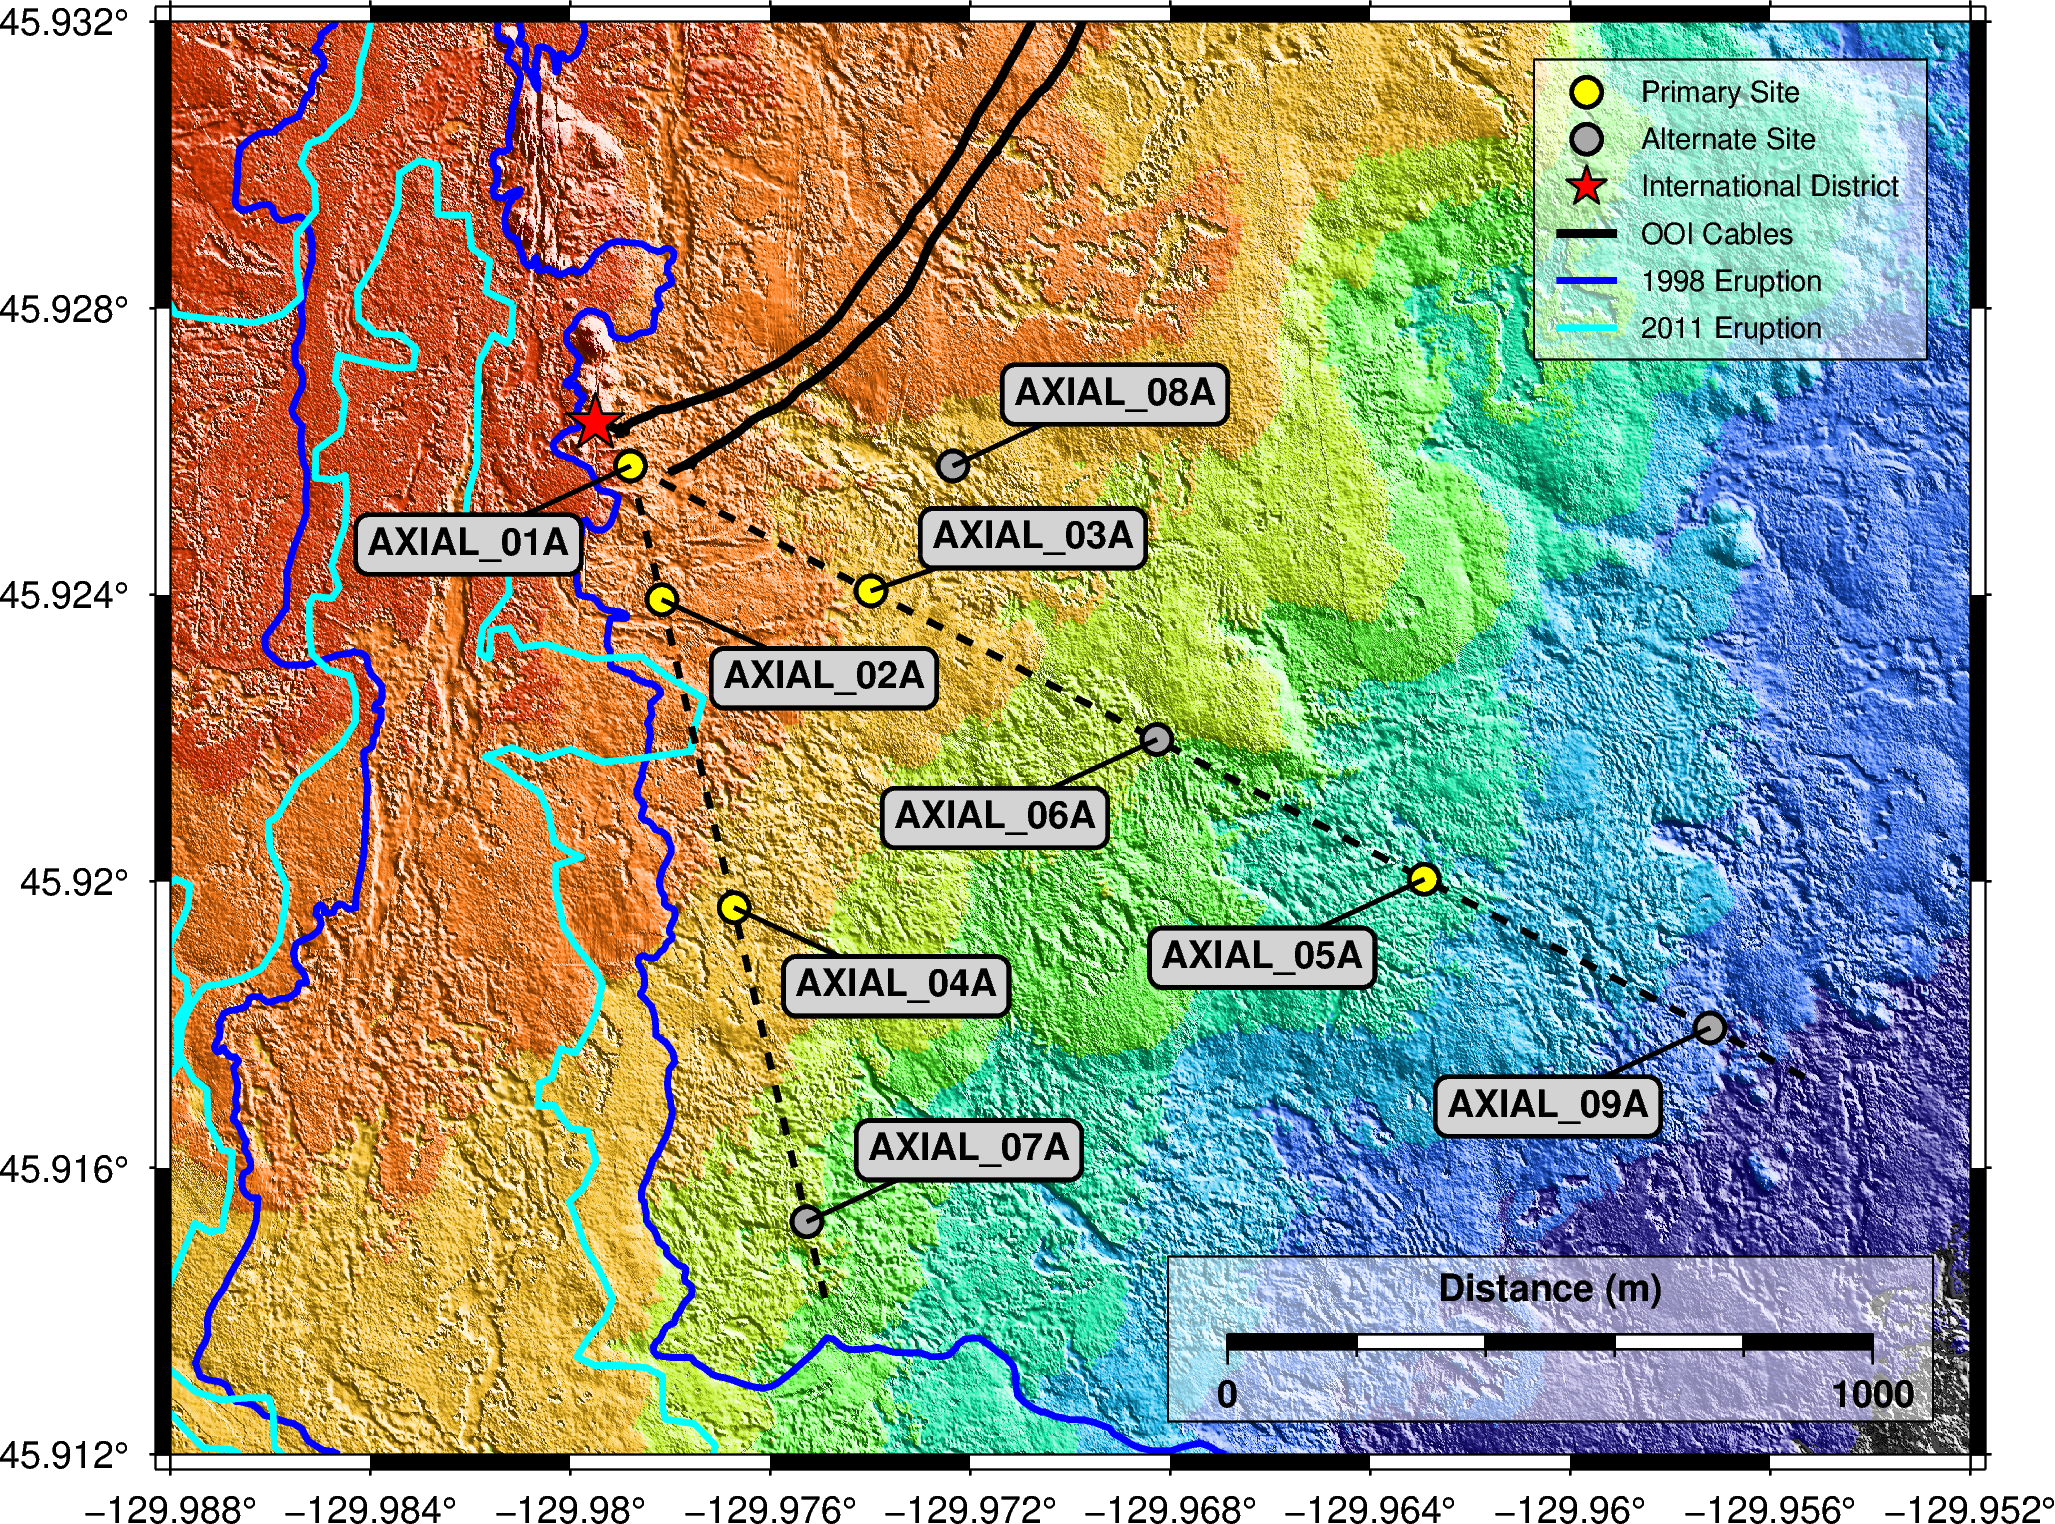

In [46]:
fig = pygmt.Figure()

# grid
fig.grdimage('%s%s' % (data_dir, bathy_grd), region=[W, E, S, N], projection='M%s/%s/6i' % (EW, NS),
             shading='shading.grd', cmap='bathy.cpt', Q='')

# lava outlines
color_1998 = 'blue'
thickness_1998 = '1.5p'
fig.plot(lava_1998_list[0].lon.values, lava_1998_list[0].lat.values, W='%s,%s' % (thickness_1998, color_1998))
fig.plot(lava_1998_list[1].iloc[0:2710].lon.values, lava_1998_list[1].iloc[0:2710].lat.values, W='%s,%s' % (thickness_1998, color_1998))
fig.plot(lava_1998_list[2].lon.values, lava_1998_list[2].lat.values, W='%s,%s' % (thickness_1998, color_1998))
fig.plot(lava_1998_list[3].lon.values, lava_1998_list[3].lat.values, W='%s,%s' % (thickness_1998, color_1998))

color_2011 = 'cyan'
thickness_2011 = '1.5p'
fig.plot(lava_2011_list[0].iloc[0:454].lon.values, lava_2011_list[0].iloc[0:454].lat.values, W='%s,%s' % (thickness_2011, color_2011)) 
fig.plot(lava_2011_list[1].iloc[0:191].lon.values, lava_2011_list[1].iloc[0:191].lat.values, W='%s,%s' % (thickness_2011, color_2011)) 
fig.plot(lava_2011_list[2].lon.values, lava_2011_list[2].lat.values, W='%s,%s' % (thickness_2011, color_2011))
fig.plot(lava_2011_list[3].iloc[0:281].lon.values, lava_2011_list[3].iloc[0:281].lat.values, W='%s,%s' % (thickness_2011, color_2011)) 
fig.plot(lava_2011_list[4].lon.values, lava_2011_list[4].lat.values, W='%s,%s' % (thickness_2011, color_2011))
fig.plot(lava_2011_list[5].lon.values, lava_2011_list[5].lat.values, W='%s,%s' % (thickness_2011, color_2011))
fig.plot(lava_2011_list[6].lon.values, lava_2011_list[6].lat.values, W='%s,%s' % (thickness_2011, color_2011))

# cables
cable_color = 'black'
cable_thickness = '2p'
for cable in ooi_cables_df.name.unique():
    cable_df = ooi_cables_df.loc[ooi_cables_df.name == cable]
    fig.plot(cable_df.lon.values, cable_df.lat.values, W='%s,%s' % (cable_thickness, cable_color))

# transects
fig.plot(np.append(holes_df[holes_df['name']=='AXIAL_01A'].lon.values, -129.97485),
         np.append(holes_df[holes_df['name']=='AXIAL_01A'].lat.values, 45.914), W='1.5p,black,4_4')
fig.plot(np.append(holes_df[holes_df['name']=='AXIAL_01A'].lon.values, -129.9553),
         np.append(holes_df[holes_df['name']=='AXIAL_01A'].lat.values, 45.91726), W='1.5p,black,4_4')

# international
fig.plot(-129.9795, 45.9264, style='a0.2i', color='red',pen='0.5p,black')

# holes
fig.plot(holes_df.iloc[0:5].lon.values, holes_df.iloc[0:5].lat.values, style='c0.1i', color='yellow', pen='1p,black')
fig.plot(holes_df.iloc[5:].lon.values, holes_df.iloc[5:].lat.values, style='c0.1i', color='darkgrey', pen='1p,black')

# define label offsets
label_dx = 0.54
label_dy = 0.25
label_offsets = [
    (-label_dx, -label_dy),
    (label_dx, -label_dy),
    (label_dx, label_dy*0.75),
    (label_dx, -label_dy),
    (-label_dx, -label_dy),
    (-label_dx, -label_dy),
    (label_dx, label_dy),
    (label_dx, label_dy),
    (-label_dx, -label_dy),]

# plot labels
for i, row in holes_df.iterrows():
    fig.text(x = row.lon, y = row.lat, text = row['name'], D='%fi/%fi+v1p' % label_offsets[i],
        font='9p,Helvetica-Bold,black', C='3p/3p+tO', G='lightgrey', W='1p,black')

# frame
pygmt.config(FONT_ANNOT_PRIMARY='9p,Helvetica')
fig.basemap(frame='a0.004d')

# scale bar
transparency = 50 # higher is more transparent
pygmt.config(FONT_ANNOT_PRIMARY='9p,Helvetica-Bold')
fig.legend(None, position='x4.6i/0.66i/2.55i/0.55i', F='+gwhite@%i+p0.3p,black' % transparency)
fig.basemap(L='fx4.6i/0.4i/%s/1000e+l"Distance (m)"' % NS)

# legend
# S [dx1 symbol size fill pen [ dx2 text ]]
pygmt.config(FONT_ANNOT_PRIMARY='7p,Helvetica')
with open('legend.txt', 'w') as f:
    f.write('S 0.12i c 0.1i yellow 1p,black 0.3i Primary Site\n')
    f.write('G 0.05i\n')
    
    f.write('S 0.12i c 0.1i darkgrey 1p,black 0.3i Alternate Site\n')
    f.write('G 0.05i\n')
    
    f.write('S 0.12i a 0.14i red 0.5p,black 0.3i International District\n')
    f.write('G 0.05i\n')
    
    f.write('S 0.12i - 0.2i - %s,%s 0.3i OOI Cables\n' % (cable_thickness, cable_color))    
    f.write('G 0.05i\n')

    f.write('S 0.12i - 0.2i - %s,%s 0.3i 1998 Eruption\n' % (thickness_1998, color_1998))
    f.write('G 0.05i\n')

    f.write('S 0.12i - 0.2i - %s,%s 0.3i 2011 Eruption\n' % (thickness_2011, color_2011))

    
fig.legend('legend.txt', position='x5.2i/4.65i/1.31i/1i', F='+gwhite@%i+p0.3p,black' % transparency)

# show
fig.show(width=700)


# To Do
# depth scale or contours 

In [47]:
fig.savefig('map_bathy.pdf')

In [ ]:
fig = pygmt.Figure()
fig.basemap(region=[W, E, S, N], projection="M-130/46/10i", frame=True)

In [ ]:
fig.grdimage('%s%s' % (data_dir, bathy_grd), region=[W, E, S, N], shading='shading.grd', cmap='bathy.cpt', Q='')

In [ ]:
#fig.grdimage(bathy_ds.depth, cmap='bathy.cpt', Q='')

In [ ]:
fig.show(width=800)

In [ ]:
# plot bathy
# *** make NaN white ***
fig = pygmt.Figure()
fig.basemap(region=[-130-3.75/60, -129-57/60, 45+54/60, 46], projection="M-130/46/10i", frame=True)
fig.grdimage('%s%s' % (data_dir, bathy_grd))
fig.show(width=400)

In [ ]:
fig_base = fig

In [ ]:
fig_base.plot(df_ooi_objects.lon.values, df_ooi_objects.lat.values, style="c0.2", color="red")
fig_base.plot(df_vents_plot.lon.values, df_vents_plot.lat.values, style="i0.3c", color="cyan")
for cable in df_ooi_cables.name.unique():
    cable_locs = df_ooi_cables.loc[df_ooi_cables.name == cable]
    fig_base.plot(df_cable_locs.lon.values, df_cable_locs.lat.values, W='1p,white')
fig_base.show(width=800)

In [ ]:
# plot bathy
# *** make NaN white ***
outfile = 'axial_auv_mbari09and11_clean_gcs_1m_v3.grd'
fig_base_zoom = pygmt.Figure()
fig_base_zoom.basemap(region=[-(130+0.5/60), -(129+58.5/60), 45+55.25/60, 45+55.5/60], projection="M-130/46/10i", frame=True)
fig_base_zoom.grdimage('%s%s' % (data_dir, outfile), shading='shading.grd')
#fig.show()

In [ ]:
fig_base_zoom_base = fig_base_zoom

In [ ]:
fig_base_zoom_base.plot(ooi_objects.lon.values, ooi_objects.lat.values, style="c0.2", color="red")
fig_base_zoom_base.plot(vents_plot.lon.values, vents_plot.lat.values, style="i0.3c", color="cyan")
for cable in ooi_cables.name.unique():
    cable_locs = ooi_cables.loc[ooi_cables.name == cable]
    fig_base_zoom_base.plot(cable_locs.lon.values, cable_locs.lat.values, W='1p,white')
fig_base_zoom_base.show(width=800)

In [ ]:
fig_base_zoom_base.plot(ooi_objects.lon.values, ooi_objects.lat.values, style="c0.2", color="red")
fig_base_zoom_base.plot(vents_plot.lon.values, vents_plot.lat.values, style="i0.3c", color="cyan")
for cable in ooi_cables.name.unique():
    cable_locs = ooi_cables.loc[ooi_cables.name == cable]
    fig_base_zoom_base.plot(cable_locs.lon.values, cable_locs.lat.values, W='1p,white')
fig_base_zoom_base.show(width=800)

### Vents

In [ ]:
fig.plot(vents_plot.lon.values, vents_plot.lat.values, style="i0.3c", color="cyan")
fig.show()

### OOI Cable Infrastructure

In [ ]:
fig.plot(ooi_objects.lon.values, ooi_objects.lat.values, style="c0.2", color="red")

In [ ]:
for cable in ooi_cables.name.unique():
    cable_locs = ooi_cables.loc[ooi_cables.name == cable]
    fig.plot(cable_locs.lon.values, cable_locs.lat.values, W='yellow')
fig.show(width=800)

---
## Interactive Plots
These plots using Holoviews and Hvplot are rough and meant for exploring the data and picking hole locations. The GMT plots below will be pulication-ready and finished once we have decided on hole locations and the elements to include.

In [ ]:
import cartopy.crs as ccrs
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import geoviews as gv
from bokeh.models import HoverTool

#### Layer 2A Thickness Overlay

In [ ]:
plot_opts = {'x': 'lon', 'y': 'lat', 'geo': True, 'hover': True, 'frame_height': 600, 'frame_width': 800}
circle_color = 'white'

In [ ]:
RS03W8_circles_hvplots = []
for RS03W8_circle in RS03W8_circles:
    RS03W8_circles_hvplots.append(RS03W8_circle.hvplot.paths(**plot_opts, c = circle_color))

In [ ]:
RS03W6_circles_hvplots = []
for RS03W6_circle in RS03W6_circles:
    RS03W6_circles_hvplots.append(RS03W6_circle.hvplot.paths(**plot_opts, c = circle_color))

In [ ]:
ooi_circles_hvplots = []
for ooi_circle in ooi_circles:
    ooi_circles_hvplots.append(ooi_circle.hvplot.paths(**plot_opts, c = circle_color))

In [ ]:
ooi_cables_hvplots = []
for name, group in ooi_cables_df.groupby('name'):
    ooi_cables_hvplots.append(group.hvplot.paths(**plot_opts, c = circle_color))

In [ ]:
lava_color = 'grey'
lava_2011_hvplots = [lava_2011_list[0].iloc[0:454].hvplot.paths(**plot_opts, c=lava_color),
  lava_2011_list[1].iloc[0:191].hvplot.paths(**plot_opts, c=lava_color),
  lava_2011_list[2].hvplot.paths(**plot_opts, c=lava_color),
  lava_2011_list[3].iloc[0:281].hvplot.paths(**plot_opts, c=lava_color),
  lava_2011_list[4].hvplot.paths(**plot_opts, c=lava_color),
  lava_2011_list[5].hvplot.paths(**plot_opts, c=lava_color),
  lava_2011_list[9].hvplot.paths(**plot_opts, c=lava_color)]

In [ ]:
lava_color = 'darkgrey'
lava_1998_hvplots = [lava_1998_list[0].hvplot.paths(**plot_opts, c=lava_color),
    lava_1998_list[1].iloc[0:2710].hvplot.paths(**plot_opts, c=lava_color),
    lava_1998_list[2].hvplot.paths(**plot_opts, c=lava_color),
    lava_1998_list[3].hvplot.paths(**plot_opts, c=lava_color)]

In [ ]:
image_hover = """
    <div style = "opacity: 1;">
        <div>
            <img
                src="@img1" height="200" alt="@imgs"
                style="float: left; margin: 0px 0px 0px 0px;"
                border="0">
            </img>
            
        </div>
        <div>
            <span style="font-weight: bold;">Cruise:</span> @cruise<br>
            <span style="font-weight: bold;">Lowering:</span> @lowering<br>
            <span style="font-weight: bold;">Event:</span> @event_number<br>
            <span style="font-weight: bold;">Depth:</span> @depth<br>
            <span style="font-weight: bold;">Comment:</span> @event


        </div>
    </div>
"""
hover = HoverTool(tooltips=image_hover)

In [ ]:
jason_points = gv.Points(
    jason_df, kdims = ['lon', 'lat'],
    vdims = ['img1', 'lowering', 'event_number','event', 'cruise', 'depth']
).opts(color='lime', tools=[hover], width=800, height=600,  projection=ccrs.GOOGLE_MERCATOR)

In [ ]:
international = [['International', 45.9264, -129.9796]]
international_df = pd.DataFrame(international, columns = ['name', 'lat', 'lon'])
international_df

In [ ]:
thickness_ds.hvplot.quadmesh(**plot_opts, hover_cols=['lon', 'lat', 'thickness']).opts(clim=(450,700)) \
  * thickness_interp_ds.hvplot.image(**plot_opts).opts(clim=(450,700)) \
  * hv.Overlay(RS03W8_circles_hvplots) \
  * hv.Overlay(RS03W6_circles_hvplots) \
  * hv.Overlay(ooi_circles_hvplots) \
  * hv.Overlay(ooi_cables_hvplots) \
  * hv.Overlay(lava_1998_hvplots) \
  * hv.Overlay(lava_2011_hvplots) \
  * vents_df.hvplot.points(**plot_opts, c='red', s=10, hover_cols=['lon', 'lat', 'name']) \
  * ooi_df.hvplot.points(**plot_opts, c='black', s=10, hover_cols=['lon', 'lat', 'name']) \
  * spiral_df_geo[0::10].hvplot.paths(**plot_opts, c='magenta') \
  * holes_df.hvplot.points(**plot_opts, c='yellow', s=100, hover_cols=['lon', 'lat', 'name', 'depth', 'thickness']) \
  * international_df.hvplot.points(**plot_opts, c='cyan', s=50)
#  * jason_points \

#### Bathy Overlay

In [ ]:
plot_opts = {'x': 'lon', 'y': 'lat', 'geo': True, 'hover': True, 'frame_height': 600, 'frame_width': 800}

In [ ]:
bathy_ds.depth[::10].hvplot.image(**plot_opts, cmap = 'bmy').opts(clim=(-1550,-1500)) \
  * hv.Overlay(RS03W8_circles_hvplots) \
  * hv.Overlay(RS03W6_circles_hvplots) \
  * hv.Overlay(ooi_circles_hvplots) \
  * hv.Overlay(ooi_cables_hvplots) \
  * hv.Overlay(lava_1998_hvplots) \
  * hv.Overlay(lava_2011_hvplots) \
  * vents_df.hvplot.points(**plot_opts, c='red', s=10, hover_cols=['lon', 'lat', 'name']) \
  * ooi_df.hvplot.points(**plot_opts, c='black', s=10, hover_cols=['lon', 'lat', 'name']) \
  * holes_df.hvplot.points(**plot_opts, c='yellow', s=100, hover_cols=['lon', 'lat', 'name', 'depth', 'thickness'])

---
## Scratch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

fontprops = fm.FontProperties(size=14, family='monospace')

bar = AnchoredSizeBar(ax.transData, 3, '3 units', 4, pad=0.5, sep=5, borderpad=0.5, frameon=True, size_vertical=0.5, color='black', fontproperties=fontprops)


fig, ax = plt.subplots()
ax.imshow(np.random.random((10,10)))
#bar = AnchoredSizeBar(ax.transData, 3, '3 data units', 4)
ax.add_artist(bar)
fig.show()

In [ ]:
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=14, family='monospace')
bar = AnchoredSizeBar(ax.transData, 3, '3 units', 4, pad=0.5, sep=5, borderpad=0.5, frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)

In [ ]:
df_rad_300_1 = circle(45.9263, -129.9791, 300)
df_rad_300_2 = circle(45.9258, -129.9776, 300)

In [ ]:
holes = [['AXIAL_01A', 45.925414, -129.977862],
         ['AXIAL_02A', 45.926026, -129.971828],
         ['AXIAL_03A', 45.916465, -129.976786],
         ['AXIAL_04A', 45.920833, -129.977222]]
holes_df = pd.DataFrame(holes, columns = ['name', 'lat', 'lon']).set_index('name')
holes_df

In [ ]:
hole_names = ['AXIAL_01A', 'AXIAL_01B',  'AXIAL_01C',  'AXIAL_01D']
axial_01A = [45.925414, -129.977862]
axial_01B = [45.926026, -129.971828]
axial_01C = [45.916465, -129.976786]
axial_01D = [45.9208333, -129.9772222]

data = [{'lat': axial_01a[0], 'lon':axial_01a[1]}, 
        {'lat': axial_01b[0], 'lon': axial_01b[1]}, 
        {'lat': axial_01c[0], 'lon': axial_01c[1]}, 
        {'lat': axial_01d[0], 'lon': axial_01d[1]}]

df_holes = pd.DataFrame(data, index =['axial_01A', 'axial_01B',  'axial_01C',  'axial_01D'])
df_holes

In [ ]:
plot_opts('x': 'lon', 'y': 'lat', 'geo': True, 'hover': True, 'frame_height': 600, 'frame_width': 800)
ds_thickness.hvplot.quadmesh(**plot_opts, hover_cols=['lon', 'lat', 'thickness']) \
  * df_vents_plot.hvplot.points(**plot_opts, c='red', s=10, hover_cols=['lon', 'lat', 'name']) \
  * df_ooi_objects_plot.hvplot.points(**plot_opts, c='black', s=10, hover_cols=['name']) \
  * df_ooi_cables_plot.hvplot.points(**plot_opts, c = 'black', s = 2) \
  * df_rad_300_1.hvplot.paths(x = 'lon', y = 'lat', geo = True, c = 'blue') \
  * df_rad_300_2.hvplot.paths(x = 'lon', y = 'lat', geo = True, c = 'blue') \
  * df_holes.hvplot.points(x = 'lon', y = 'lat', geo = True, c = 'yellow')

In [ ]:
df_ooi_cables_plot.hvplot.line(x = 'lon', y = 'lat', geo = True, by = 'name', c = 'red', dynamic = False)

In [ ]:
ax = plt.axes(projection=ccrs.Mercator())
ds.thickness.plot(x = 'lon', y = 'lat')
#ax.stock_img()
plt.show()

In [ ]:
proj = ccrs.Mercator()
plt.figure(figsize=(30,20))
ax = plt.axes(projection=proj)

#ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
#ax.coastlines(zorder=1)
xticks = range(0, 361, 10000)
ax.set_xticks(xticks, crs=proj)
yticks = range(-90, 91, 30)
ax.set_yticks(yticks, crs=proj)
#ax.set_title('central longitude = 180')
ax.scatter(x = ds.lon, y = ds.lat, s=0.1);

In [ ]:
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

gv.extension('bokeh', 'matplotlib')

In [ ]:
#scatter = hv.Scatter(data=df, kdims = ['lon', 'lat'], vdims=['thickness'])
scatter = hv.Scatter(data=df, vdims = ['lon', 'lat', 'thickness'])
scatter.opts(frame_width=600, frame_height=600, colorbar=True, axiswise=True)

In [ ]:
scatter = hv.Scatter(ds, vdims=['lon', 'lat', 'thickness'])
scatter

In [ ]:
qmesh = gv.Dataset(ds.thickness).to(gv.QuadMesh)

In [ ]:
gvds = gv.Dataset(ds)
gvds

In [ ]:
type(gvds)

In [ ]:
import geoviews as gv
gv.extension('bokeh')
import holoviews as hv

In [ ]:
quadmesh.thickness.to(hv.HoloMap)

In [ ]:
quadmesh = gvds.to(gv.QuadMesh, ['lon', 'lat'])

In [ ]:
type(quadmesh)

In [ ]:
quadmesh

In [ ]:
qmesh = gv.Dataset(ds.thickness[::3,::2]).to(gv.QuadMesh, groupby='time')

In [ ]:
type(qmesh)

In [ ]:
type(rasm.Tair)

In [ ]:
type(ds.thickness)

In [ ]:
rasm.Tair

In [ ]:
ds.thickness

In [ ]:
gvds = gv.Dataset(ds, ['lon', 'lat'], 'thickness', crs=crs.Mercator())
#images = dataset.to(gv.Image)
gvds

In [ ]:
qmesh = gv.Dataset(ds.thickness).to(gv.QuadMesh)

In [ ]:
qmesh = gvds.to(gv.QuadMesh)

In [ ]:
qmesh.to(hv.HoloMap)

In [ ]:
dir(qmesh)

In [ ]:
qmesh.opts(projection=ccrs.Mercator())

In [ ]:
gmesh

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.thickness.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);

In [ ]:
ds.to_netcdf('../data/test.nc')

In [ ]:
data_dir = '/home/jovyan/github/ooicloud/axial-drilling/maps/data/'
depth_file = 'test.nc'
fig = pygmt.Figure()
fig.basemap(region=[-130-3.75/60, -129-57/60, 45+54/60, 46], projection="M-130/46/10i", frame=True)
fig.grdimage('%s%s' % (data_dir, depth_file))

In [ ]:
# create a grid that spans 0 359 E, and -89 to 90 N.
longitude = np.arange(0, 360, 1)
latitude = np.arange(-89, 91, 1)
x = np.sin(np.deg2rad(longitude))
y = np.linspace(start=0, stop=1, num=180)
data = y[:, np.newaxis] * x

# create a DataArray, and then export this as a netcdf file
dataarray = xr.DataArray(data, coords=[('latitude', latitude,
                                       {'units': 'degrees_north'}),
                                       ('longitude', longitude,
                                       {'units': 'degrees_east'})], 
                         attrs = {'actual_range': [-1, 1]})
dataset = dataarray.to_dataset(name='dataarray')
dataset.to_netcdf('test.grd')

fig = pygmt.Figure()

# create a projected image using the DataArray in memory and the netcdf file
fig.grdimage(dataset.dataarray, region='g', projection='A0/0/6i')
fig.grdimage('test.grd', region='g', projection='A0/0/6i', X='6.2i')
    

In [ ]:
fig.show()

In [ ]:
import xarray as xr
import cartopy.crs as ccrs
import geoviews as gv

gv.extension('matplotlib')
gv.output(fig='svg', size=300)

In [ ]:
qmeshes.opts(projection=ccrs.GOOGLE_MERCATOR)

In [ ]:
tiles = gv.tile_sources.EsriImagery
rasm = xr.tutorial.open_dataset('rasm').load()
qmeshes = gv.Dataset(rasm.Tair[::4, ::3, ::3]).to(gv.QuadMesh, groupby='time')

---
## Clean up GRD files
Only do once!

In [ ]:
import os
import pygmt

In [ ]:
# clip bad values
data_dir = '/home/jovyan/github/ooicloud/axial-drilling/maps/data/'

infile = 'axial_auv_mbari09and11n_gcs_1m_v3.grd'
tmpfile1 = 'tmp1.grd'
cmd = ('gmt grdclip %s%s -G%s%s -Sb-1600/NaN -Sa1500/NaN' % (data_dir, infile, data_dir, tmpfile1))
os.system(cmd);

infile = 'axial_auv_mbari09and11c_gcs_1m_v3.grd'
tmpfile2 = 'tmp2.grd'
cmd = ('gmt grdclip %s%s -G%s%s -Sb-1600/NaN -Sa1500/NaN' % (data_dir, infile, data_dir, tmpfile2))
os.system(cmd);

infile = 'axial_auv_mbari09and11s_gcs_1m_v3.grd'
tmpfile3 = 'tmp3.grd'
cmd = ('gmt grdclip %s%s -G%s%s -Sb-1600/NaN -Sa1500/NaN' % (data_dir, infile, data_dir, tmpfile3))
os.system(cmd);

In [ ]:
# blend GRD files
tmpfile4 = 'tmp4.grd'
cmd = ('gmt grdblend %s%s %s%s -G%s%s' % (data_dir, tmpfile1, data_dir, tmpfile2, data_dir, tmpfile4))
os.system(cmd);

tmpfile5 = 'tmp5.grd'
cmd = ('gmt grdblend %s%s %s%s -G%s%s' % (data_dir, tmpfile4, data_dir, tmpfile3, data_dir, tmpfile5))
os.system(cmd);

In [ ]:
# crop region
bathy_grd = 'axial_auv_mbari09and11_clean_gcs_1m_v3.grd'
cmd = ('gmt grdcut %s%s -G%s%s -R%0.8f/%0.8f/%0.8f/%0.8f' % (data_dir, tmpfile5, data_dir, bathy_grd, -130-3.75/60, -129-57/60, 45+54/60, 46))
os.system(cmd);

In [ ]:
# clean up
os.system('rm %s%s' % (data_dir, tmpfile1));
os.system('rm %s%s' % (data_dir, tmpfile2));
os.system('rm %s%s' % (data_dir, tmpfile3));
os.system('rm %s%s' % (data_dir, tmpfile4));
os.system('rm %s%s' % (data_dir, tmpfile5));
os.system('rm %s%s' % (data_dir, tmpfile1));
os.system('rm %s%s' % (data_dir, tmpfile1));